In [4]:
import pandas as pd
import numpy as np
import os
import random
import json
import tiktoken
from transformers import AutoTokenizer
from huggingface_hub import login
from evaluation_funcs import load_txt_files_to_df
import seaborn as sns
import matplotlib.pyplot as plt
from evaluate import load
import re
from datasets import Dataset, DatasetDict

from openai import OpenAI
client = OpenAI()

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
login()

In [6]:
def save_openai_batch_result(batch_file, jsonl_file):

    """ 
    Small function to help keep the openai batch process clean. downloads the batch file and saves it as a jsonl file
    """

    result = client.files.content(batch_file).content

    with open(jsonl_file, 'wb') as file:
        file.write(result)


def convert_opanai_jsonl_to_df(jsonl_file):

    """ 
    Loads a jsonl file returned from the openai batch process. Returns a dataframe containing only the most useful information
    """

    results = []
    with open(jsonl_file, 'r') as file:
        for line in file:
            # Parsing the JSON string into a dict and appending to the list of results
            json_object = json.loads(line.strip())
            necessary_data = {
                'id': json_object['custom_id'],
                'post_lm_text': json_object['response']['body']['choices'][0]['message']['content']
            }
            necessary_data.update(json_object['response']['body']['usage'])
            results.append(necessary_data)
    return pd.DataFrame(results)

def pre_evaluation_processing(df, ground_truth_df, post_lm_text, gt_text ):
    df['id'] = df['id'].str.replace('filename_', '')

    df = df.merge(ground_truth_df.set_index('file_name'), left_on = 'id', right_index = True)
    #df['post_lm_text2'] = df['post_lm_text'].apply(extract_first_match)
    df[post_lm_text] = df[post_lm_text].str.replace("\n*", " ").str.lower()
    df[gt_text] = df[gt_text].str.replace("\n*", " ").str.lower()
    df.reset_index(inplace=True)

    return df

def evaluate_model(df, metric_obj, gt_text, post_lm_text, metric_name = 'cer'):

    """ 
    Uses a huggingface metric to evaluate the results
    """
    
    # Calculate CER for each pair
    results = []
    for index, row in df.iterrows():
        ground_truth_text = row[gt_text]
        response_text = row[post_lm_text]
        result = metric_obj.compute(predictions=[response_text], references=[ground_truth_text])
        results.append(result)

    df[metric_name] = results

    return df


# Create the silverset

- set seed
- for each file
    - load file
    - remove all entries greater than smaller than 100 tokens, above acceptable noise

- concatenate to single data frame




In [133]:
#temp_df = pd.read_parquet('./data/ncse_text_chunks2/'+'ncse_base_1.parquet')

In [134]:
target_dir = './data/transcripts/transcription_files'

files_in_directory =  set(os.listdir(target_dir))

all_data_df = []

for file in os.listdir('./data/ncse_text_chunks'):

     temp_df = pd.read_parquet('./data/ncse_text_chunks/'+file)
     temp_df['entire_article'] = temp_df[['continuation_from_id','continuation_to_id']].isna().sum(axis = 1)==2
     temp_df =  temp_df.loc[temp_df['total_tokens']>100,['id', 'total_tokens', 'symbol_fract', 'entire_article','publication_id', 'file_name', 'content_html']]
     all_data_df.append(temp_df)

all_data_df = pd.concat(all_data_df)


In [135]:
#proper tokenization is important as llama3 has 3x the vocabulary so will produce fewer tokens for a given text than llama2

In [10]:
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [137]:
def extract_first_x_tokens(text, tokenizer, max_tokens = 1000):
    """
    Extract the first 1000 tokens from a string using the hugginface tokenizer. It ensures that
    the number of tokens in each string does not exceed the limit for a specific model or
    finetuning budget

    Parameters:
    text (str): The input string.
    tokenizer: The tokenizer object for the model of interest
    max_tokens: The maximum number of tokens

    Returns:
    str: The string containing the first 1000 tokens.
    """

    # Tokenize the input text
    tokens = tokenizer.encode(text)

    # Extract the first x tokens
    first_x_tokens = tokens[:max_tokens]

    # Decode the tokens back to string
    truncated_text = tokenizer.decode(first_x_tokens)
    #re-calc total tokens in text
    total_tokens = len(first_x_tokens)

    return truncated_text, total_tokens

random.seed(12335)
#remove the transcribed data then sample. This is to keep the test set pure
sampled_data = all_data_df.loc[~all_data_df['file_name'].isin(os.listdir('./data/transcripts/transcription_files')),:].sample(11000) #11000
#reduce to a maximum token size of 1000
sampled_data[['content_html', 'total_tokens_llama']] = sampled_data['content_html'].apply(lambda x: pd.Series(extract_first_x_tokens(x, tokenizer)))
omni_tokenizer = tiktoken.get_encoding("o200k_base")
sampled_data[['content_html_drop', 'total_tokens_omni']] = sampled_data['content_html'].apply(lambda x: pd.Series(extract_first_x_tokens(x, omni_tokenizer, max_tokens=10000)))
sampled_data = sampled_data.drop('content_html_drop', axis = 1)
sampled_data.to_parquet('./data/silver_data.parquet')

In [138]:
sampled_data = pd.read_parquet('./data/silver_data.parquet')


In [139]:
temp_df.describe()

,id,total_tokens,symbol_fract,publication_id
count,6.095500e+04,60955.000000,60955.000000,60955.000000
mean,7.958790e+05,1050.931179,0.296191,25.496711
std,1.082284e+05,1034.516097,0.195823,2.282060
min,4.077390e+05,101.000000,0.040201,19.000000
25%,7.398090e+05,267.000000,0.166518,26.000000
50%,7.748910e+05,670.000000,0.240628,26.000000
75%,8.280760e+05,1508.000000,0.346423,27.000000
max,1.068904e+06,10297.000000,2.920792,27.000000


<Axes: xlabel='total_tokens_llama', ylabel='Count'>

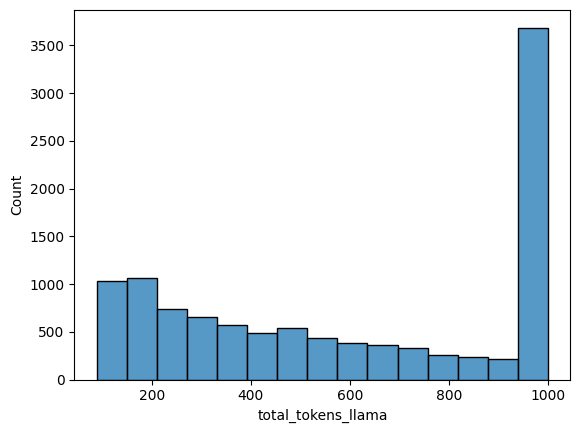

In [140]:
temp_df = sampled_data
temp_df['ratio'] = sampled_data['total_tokens_llama']/sampled_data['total_tokens_omni']
sns.histplot(data = sampled_data, x = 'total_tokens_llama')

In [141]:
sampled_data['total_tokens_llama'].describe()

count    11000.000000
mean       599.866455
std        340.155148
min         89.000000
25%        264.000000
50%        570.000000
75%       1000.000000
max       1000.000000
Name: total_tokens_llama, dtype: float64

In [142]:
for index, row in sampled_data.iterrows():
    text = row['article_text']
    filename = row['file_name']
    file_path = os.path.join('./data/silver_ocr', filename)

    # Write the text to the file
    with open(file_path, 'w') as file:
        file.write(text)


KeyError: 'article_text'

In [19]:
def create_jsonl_file(df, model, system_content, max_tokens, output_file, include_response = False):
    """
    Create a JSONL file for batch jobs or fine tuning in OpenAI format.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    model (str): The model to be used in the 'body' of the JSON.
    system_content (str): The content for the system message.
    max_tokens (int): The max tokens value.
    output_file (str): The path to the output JSONL file.
    include_response (bool): Whether to include the model response in the messages list.
    """
    with open(output_file, 'w') as file:
        for _, row in df.iterrows():
            messages = [
                {"role": "system", "content": system_content}
            ]
            if include_response:
                messages.append({"role": "user", "content": row['raw_text']})
                messages.append({"role": "assistant", "content": row["article_text"]})
            else:
                messages.append({"role": "user", "content": row['article_text']})

            entry = {
                "custom_id": f"filename_{row['file_name']}",
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": model,
                    "messages": messages,
                    "max_tokens": max_tokens
                }
            }
            # Write each JSON object as a separate line in the JSONL file
            file.write(json.dumps(entry) + '\n')



# Specify the arguments
model = 'gpt-4o'
system_content = "You are an expert in recovery of corrupted OCR, the below text is from an English newspaper in the 1800's, please return in plain text, with appropriate spacing and line breaks"
max_tokens = 2200
output_file = './data/output.jsonl'

# Call the function with the DataFrame and arguments
#create_jsonl_file(sampled_data.reset_index().loc[0:20,:], model, system_content, max_tokens, output_file)


First example taken from the hansard "Disfranchisement Of Sudbury"

https://hansard.parliament.uk/commons/1842-07-06/debates/bd9ca32b-d1b2-4337-bc00-32deed2899e7/DisfranchisementOfSudbury

In [22]:
#silver_instructions_base = "You are an expert in post-OCR correction of documents. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. Do not write anything else than the corrected text."
#silver_instructions_between = "You are an expert in post-OCR correction of documents. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. Do not write anything else than the corrected text. place the corrected text between the symbols '</corrected>'"
silver_instructions_historical = "You are an expert in post-OCR correction of historical newspapers. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. Do not write anything else than the corrected text."
silver_instructions_ICL = """You are an expert in post-OCR correction of documents. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software.Do not write anything else than the corrected text. 
As an example consider the following texts

{
  "corrupted": "The populatlon of that hundrea amounteo to 24,069, ancl he bel1eved that if they ex tenclsd the borou#h, as he des1red, they woulcl secur@ an additlon to the prsent constituen€y of at least 1,000 votors."
  "recovered": "The population of that hundred amounted to 24,069, and he believed that if they extended the borough, as he desired, they would secure an addition to the present constituency of at least 1,000 voters.",
}

{
  "corrupted": "Th3 park 1s a b3autiful pl@ce w1th lush gree.n l@wns, tall tre.es, an& a serene laKe wh3re v1sitors can .*-enjoy a peac3ful walk or a relax1ng boat ride..."
  "recovered": "The park is a beautiful place with lush green lawns, tall trees, and a serene lake where visitors can enjoy a peaceful walk or a relaxing boat ride.",
}

{
  "corrupted": "The res#aurant ser\\es a variet¥ of dis#es, includin fresh seafo9d, sa&ory s+eaks, and delici0us vegetarain opti0ns, al prep*red wth the finset ingrdients."
  "recovered": "The restaurant serves a variety of dishes, including fresh seafood, savory steaks, and delicious vegetarian options, all prepared with the finest ingredients.",
}

You need only return the recovered text

"""


silver_instructions_longprompt = """You are an expert in post-OCR correction of documents. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. Pay close attention to common OCR errors such as misrecognized characters, incorrect spacing, and punctuation issues.


To complete this task, follow these steps:

1. Read through the entire text to understand the context and identify potential errors.
2. Correct any misrecognized characters, such as:
   - Numbers mistaken for letters (e.g., '0' for 'O', '1' for 'I', '5' for 'S')
   - Similar-looking letters (e.g., 'rn' for 'm', 'cl' for 'd')
   - Special characters mistaken for letters or punctuation
3. Fix any spacing issues, ensuring proper word separation and sentence structure.
4. Correct punctuation errors, including misplaced or missing periods, commas, and quotation marks.
5. Ensure proper capitalization, especially at the beginning of sentences and for proper nouns.
6. Maintain the original formatting and structure of the text as much as possible.

Provide your corrected version of the text without any additional explanations or comments. Your output should contain only the corrected text, preserving the original paragraph structure and line breaks.

Begin your corrected text immediately after this instruction, without any introductory phrases or explanations."""

#create_jsonl_file(sampled_data.reset_index().loc[0:20,:], model, silver_instructions_base, max_tokens, './data/silver_instructions_base.jsonl')
#create_jsonl_file(sampled_data.reset_index().loc[0:20,:], model, silver_instructions_between, max_tokens, './data/silver_instructions_between.jsonl') using this doesn't work as the model does not reliably return the symbols correctly.
create_jsonl_file(sampled_data.reset_index().loc[0:20,:], model, silver_instructions_historical, max_tokens, './data/test_prompt_ready_to_batch/silver_instructions_historical.jsonl')
create_jsonl_file(sampled_data.reset_index().loc[0:20,:], model, silver_instructions_ICL, max_tokens, './data/test_prompt_ready_to_batch/silver_instructions_ICL.jsonl')

NameError: name 'sampled_data' is not defined

In [ ]:


batch_input_file = client.files.create(
  file=open('./data/silver_instructions_base.jsonl', "rb"),
  purpose="batch"
)

In [ ]:
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "silver_instructions_base"
    }
)

Batch(id='batch_FnoK5q5bQOAKs9GfPOdRdlpi', completion_window='24h', created_at=1720984280, endpoint='/v1/chat/completions', input_file_id='file-bNxRuQZxubqvLpqiAgPpMffe', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1721070680, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'silver_instructions_base'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [ ]:
batch_data = client.batches.list(limit=2)
batch_data.data

[Batch(id='batch_SDus5Sr3PQiFTMVyOLDGhBd2', completion_window='24h', created_at=1721735519, endpoint='/v1/chat/completions', input_file_id='file-zgzs5sRSm2vEJ4Y33iZdJedY', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1721735669, error_file_id=None, errors=None, expired_at=None, expires_at=1721821919, failed_at=None, finalizing_at=1721735665, in_progress_at=1721735519, metadata={'description': 'silver_instructions_longprompt'}, output_file_id='file-8ANGDnRRYSCe8bQc4ZhYvl3p', request_counts=BatchRequestCounts(completed=91, failed=0, total=91)),
 Batch(id='batch_BeCCUmTFEoc4hAv08gVctYT5', completion_window='24h', created_at=1721733210, endpoint='/v1/chat/completions', input_file_id='file-s2IM3wrz0wyRbgHtIBPg2uLf', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1721733272, error_file_id=None, errors=None, expired_at=None, expires_at=1721819610, failed_at=None, finalizing_at=1721733269, in_progress_at=172173

In [ ]:
raw_gold_ocr_df

,article_text,file_name,id,total_tokens
0,"MONOMANIA . 5 ISCB Ox ? 0 BD "" popped"" at the ...",artid_841530_periodical_ns_issue_vm2-ncseprodu...,841530,1130
1,* The Plague and the Printing Press : being a ...,artid_751411_periodical_pc_issue_tec_01051889_...,751411,270
2,"he performed upon diverse of the foremost , wh...",artid_871466_periodical_ns_issue_ns2_02101852_...,871466,1719
3,be having necessary to tramp for the into hous...,artid_494321_periodical_ewj_issue_ewj_01051860...,494321,620
4,tomorrow we are going * to pillage the archbis...,artid_495935_periodical_ewj_issue_ewj_01011860...,495935,770
...,...,...,...,...
86,because too much power was placed in the hands...,artid_841528_periodical_ns_issue_vm2-ncseprodu...,841528,890
87,^ ^ ^ ^ ^^ ¦ ¦ ¦¦ ¦¦¦¦¦¦¦ ^ ¦¦ ¦ ¦ ^ ^ ¦ ^ ^ ¦...,artid_766218_periodical_pc_issue_tec_01031886_...,766218,137
88,Boo &§; and ^ mou ^ ofBoo & £ Miss Braddon avv...,artid_771187_periodical_pc_issue_tec_15091890_...,771187,1250
89,have been-designed : ihere may therefore be th...,artid_653700_periodical_mruc_issue_vm2-ncsepro...,653700,510


In [ ]:
raw_transcript_oct_folder = './data/transcripts/transcription_raw_ocr'

#These are referred to as "gold" as this clearly distinguishes the dataset from any dataframes called test or for testing things in general
raw_gold_ocr_df = load_txt_files_to_df(raw_transcript_oct_folder)
raw_gold_ocr_df['id'] = raw_gold_ocr_df['file_name'].str.split("_periodical", expand = True)[0].str.replace("artid_", "")

enc = tiktoken.get_encoding('o200k_base')
raw_gold_ocr_df['total_tokens'] = raw_gold_ocr_df['article_text'].apply(lambda x:len(enc.encode(x)))

max_tokens = 4000


create_jsonl_file(raw_gold_ocr_df, model, silver_instructions_historical, max_tokens, './data/test_prompt_ready_to_batch/silver_instructions_historical.jsonl')
create_jsonl_file(raw_gold_ocr_df, model, silver_instructions_ICL, max_tokens, './data/test_prompt_ready_to_batch/silver_instructions_ICL.jsonl')

create_jsonl_file(raw_gold_ocr_df, model, silver_instructions_longprompt, max_tokens, './data/test_prompt_ready_to_batch/silver_instructions_longprompt.jsonl')


In [ ]:
batch_input_file = client.files.create(
  file=open('./data/test_prompt_ready_to_batch/silver_instructions_longprompt.jsonl', "rb"),
  purpose="batch"
)

batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "silver_instructions_longprompt"
    }
)

Batch(id='batch_SDus5Sr3PQiFTMVyOLDGhBd2', completion_window='24h', created_at=1721735519, endpoint='/v1/chat/completions', input_file_id='file-zgzs5sRSm2vEJ4Y33iZdJedY', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1721821919, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'silver_instructions_longprompt'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [ ]:
file_response = client.files.content('file-NHwN8bGdp9xpveBt1rX8LF2V')

NameError: name 'client' is not defined

In [ ]:
def save_batch_data(json_string, output_file):
    """
    Save a string containing multiple JSON objects as a JSONL file.

    Parameters:
    json_string (str): The input string containing JSON objects.
    output_file (str): The path to the output JSONL file.
    """
    # Split the string into individual JSON objects (assuming they are newline-separated)
    json_objects = json_string.strip().split('\n')
    
    with open(output_file, 'w') as file:
        for json_object in json_objects:
            # Convert the string to a dictionary to ensure it is valid JSON
            json_dict = json.loads(json_object)
            # Write the JSON object as a single line
            file.write(json.dumps(json_dict) + '\n')

In [ ]:
save_batch_data(file_response.text, './data/test_return.jsonl')

In [ ]:
def convert_batch_to_dataframe(json_string):
    """
    Extract 'custom_id', 'assistant' 'content', and 'usage' from a JSON string and create a DataFrame.

    Parameters:
    json_string (str): The input string containing JSON objects.

    Returns:
    pd.DataFrame: DataFrame containing the extracted data.
    """
    json_objects = json_string.strip().split('\n')
    extracted_data = []

    for json_object in json_objects:
        data = json.loads(json_object)
        custom_id = data['custom_id']
        assistant_content = data['response']['body']['choices'][0]['message']['content']
        usage = data['response']['body']['usage']
        
        row_data = {
            'id': custom_id,
            'corrected_content': assistant_content
        }
        
        # Add the usage dictionary to the row data
        row_data.update(usage)
        
        extracted_data.append(row_data)

    return pd.DataFrame(extracted_data)

In [ ]:
silver_corrected = convert_batch_to_dataframe(file_response.text)

,id,corrected_content,prompt_tokens,completion_tokens,total_tokens
0,request-841530,"MONOMANIA. ISCB—Oh? The Queen has ""popped"" at ...",1182,1062,2244
1,request-751411,* The Plague and the Printing Press: being a B...,322,158,480
2,request-871466,"He performed upon divers of the foremost, who,...",1771,1668,3439
3,request-494321,be having necessary to tramp for the into hous...,672,573,1245
4,request-495935,"""Tomorrow we are going to pillage the archbish...",822,709,1531
...,...,...,...,...,...
86,request-841528,because too much power was placed in the hands...,942,797,1739
87,request-766218,^ ^ ^ ^ ^ ^ ¦ ¦ ¦¦ ¦¦¦¦¦¦¦ ^ ¦¦ ¦ ¦ ^ ^ ¦ ^ ^ ...,189,117,306
88,request-771187,Boo & Co. and in lieu of Miss Braddon's new no...,1302,653,1955
89,request-653700,have been designed: there may therefore be the...,562,456,1018


In [9]:
cer = load("cer")
wer = load("wer")


In [5]:
corrected_transcript_oct_folder = "./data/transcripts/transcription_files"

corrected_gold_ocr_df = load_txt_files_to_df(corrected_transcript_oct_folder)

raw_ocr_df = load_txt_files_to_df("./data/transcripts/transcription_raw_ocr")
raw_ocr_df = raw_ocr_df.rename(columns={'article_text':'post_lm_text', 'file_name':'id'})

corrected_gold_ocr_df = pre_evaluation_processing(raw_ocr_df, corrected_gold_ocr_df, post_lm_text= 'post_lm_text', gt_text = 'article_text' )
corrected_gold_ocr_df = evaluate_model(df = corrected_gold_ocr_df, metric_obj = cer, gt_text = 'article_text', post_lm_text = 'post_lm_text')
corrected_gold_ocr_df.rename(columns = {'cer':'cer_orig', 'id':'file_name'}, inplace=True)
corrected_gold_ocr_df.drop(columns=['index', 'post_lm_text'], inplace=True)

corrected_gold_ocr_df

,file_name,article_text,cer_orig
0,artid_841530_periodical_ns_issue_vm2-ncseprodu...,"monomania.\n\nsince oxford ""popped"" at the que...",0.052256
1,artid_751411_periodical_pc_issue_tec_01051889_...,‘the plague and the printing press: being a bi...,0.481586
2,artid_871466_periodical_ns_issue_ns2_02101852_...,"he performed upon diverse of the foremost, who...",0.044863
3,artid_494321_periodical_ewj_issue_ewj_01051860...,having to tramp into some dirty court in searc...,0.151261
4,artid_495935_periodical_ewj_issue_ewj_01011860...,tomorrow we are going to pillage the archbisho...,0.123429
...,...,...,...
86,artid_841528_periodical_ns_issue_vm2-ncseprodu...,because too much power was placed in the hands...,0.060137
87,artid_766218_periodical_pc_issue_tec_01031886_...,"electrotypes. \nmessrs. sampson low, marston, ...",0.753086
88,artid_771187_periodical_pc_issue_tec_15091890_...,books and rumours of books\n\nmiss braddon's n...,0.696710
89,artid_653700_periodical_mruc_issue_vm2-ncsepro...,have been designed: there may therefore be the...,0.061052


In [ ]:

batch_file = 'file-NHwN8bGdp9xpveBt1rX8LF2V'

jsonl_file =  "./data/batch_job_results_furniture.jsonl"


In [ ]:
batch_data.data

[Batch(id='batch_JUrnd5Vr4ULIoC9dVxZu29ve', completion_window='24h', created_at=1721732615, endpoint='/v1/chat/completions', input_file_id='file-2vSKGccZmNhYyAYIIFzjx6HL', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1721732669, error_file_id=None, errors=None, expired_at=None, expires_at=1721819015, failed_at=None, finalizing_at=1721732665, in_progress_at=1721732615, metadata={'description': 'silver_instructions_ICL'}, output_file_id='file-8EMaqLAJRHqOd8gs5SzggTG2', request_counts=BatchRequestCounts(completed=91, failed=0, total=91)),
 Batch(id='batch_dz5APpniHldq490XDCtPrQbS', completion_window='24h', created_at=1721732600, endpoint='/v1/chat/completions', input_file_id='file-7xe6NOtw0HiXXKKprCuSGwFd', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1721732667, error_file_id=None, errors=None, expired_at=None, expires_at=1721819000, failed_at=None, finalizing_at=1721732664, in_progress_at=1721732600, m

In [ ]:

#save_openai_batch_result('file-8aGk8M9n5VIyQsySW7UqnnQc',  './data/test_prompt_results/silver_instructions_historical.jsonl')
save_openai_batch_result('file-8ANGDnRRYSCe8bQc4ZhYvl3p',  './data/test_prompt_results/silver_instructions_longprompt.jsonl')

In [ ]:
silver_instructions_between = convert_opanai_jsonl_to_df('./data/test_prompt_results/silver_instructions_ICL.jsonl')
silver_instructions_between = pre_evaluation_processing(silver_instructions_between, corrected_gold_ocr_df, post_lm_text= 'post_lm_text', gt_text = 'article_text' )

silver_instructions_between = evaluate_model(df = silver_instructions_between, metric_obj = cer, gt_text = 'article_text', post_lm_text = 'post_lm_text')
silver_instructions_between['ERP'] = (silver_instructions_between['cer_orig'] - silver_instructions_between['cer'])/silver_instructions_between['cer_orig'] 
silver_instructions_between[['cer', 'ERP']].describe()

,cer,ERP
count,91.000000,91.000000
mean,0.194177,0.559327
std,0.212007,0.272929
min,0.000000,-0.088000
25%,0.009783,0.295848
50%,0.102807,0.564295
75%,0.365254,0.818007
max,1.048387,1.000000


In [ ]:
silver_instructions_between = convert_opanai_jsonl_to_df('./data/test_prompt_results/silver_instructions_historical.jsonl')
silver_instructions_between = pre_evaluation_processing(silver_instructions_between, corrected_gold_ocr_df, post_lm_text= 'post_lm_text', gt_text = 'article_text' )

silver_instructions_between = evaluate_model(df = silver_instructions_between, metric_obj = cer, gt_text = 'article_text', post_lm_text = 'post_lm_text')
silver_instructions_between['ERP'] = (silver_instructions_between['cer_orig'] - silver_instructions_between['cer'])/silver_instructions_between['cer_orig'] 
silver_instructions_between[['cer', 'ERP']].describe()

,cer,ERP
count,91.000000,91.000000
mean,0.179128,0.599517
std,0.195479,0.250826
min,0.000000,-0.031642
25%,0.009184,0.425103
50%,0.094840,0.617108
75%,0.338043,0.826114
max,0.758065,1.000000


In [ ]:
silver_instructions_between = convert_opanai_jsonl_to_df('./data/test_prompt_results/silver_instructions_longprompt.jsonl')
silver_instructions_between = pre_evaluation_processing(silver_instructions_between, corrected_gold_ocr_df, post_lm_text= 'post_lm_text', gt_text = 'article_text' )

silver_instructions_between = evaluate_model(df = silver_instructions_between, metric_obj = cer, gt_text = 'article_text', post_lm_text = 'post_lm_text')
silver_instructions_between['ERP'] = (silver_instructions_between['cer_orig'] - silver_instructions_between['cer'])/silver_instructions_between['cer_orig'] 
silver_instructions_between[['cer', 'ERP']].describe()

,cer,ERP
count,91.000000,91.000000
mean,0.193581,0.550641
std,0.212895,0.259574
min,0.001185,-0.088000
25%,0.011301,0.336447
50%,0.094840,0.514596
75%,0.367834,0.795190
max,1.103226,0.947368


# Create training dataset from SMH from trove

To prevent using huge amounts of RAM when fine tuning a LLama model the training texts will be truncated to 1000 tokens

In [14]:

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B')


def trim_text_to_token_limit(df, col1, col2, max_tokens):
    """
    Trims the text in two specified columns of a DataFrame so that neither
    text string exceeds a specified token limit.

    This function splits the text in the specified columns by line breaks,
    then iteratively removes the last line from both texts until neither
    text string exceeds the given token limit when encoded using a tokenizer.

    Args:
        df (pd.DataFrame): The DataFrame containing the text columns to be trimmed.
        col1 (str): The name of the first text column.
        col2 (str): The name of the second text column.
        max_tokens (int): The maximum allowed number of tokens for each text string.

    Returns:
        pd.DataFrame: The DataFrame with the text columns trimmed to the specified token limit.
    """
    def trim_pair(text1, text2, max_tokens):
        # Split the text into lines
        lines1 = text1.split("\n")
        lines2 = text2.split("\n")

        # Ensure the number of elements in both lists is the same
        assert len(lines1) == len(lines2), "Lists must have the same number of elements"
        
        # Join the lists to check token count
        joined_text1 = " ".join(lines1)
        joined_text2 = " ".join(lines2)
        
        # While loop to trim the text until within token limit
        while len(tokenizer.encode(joined_text1)) > max_tokens or len(tokenizer.encode(joined_text2)) > max_tokens:
            if lines1:
                lines1.pop()
            if lines2:
                lines2.pop()
            joined_text1 = " ".join(lines1)
            joined_text2 = " ".join(lines2)
        
        #Add the line breaks back in and return the truncated strings
        return "\n".join(lines1),  "\n".join(lines2)
    
    # Apply the trimming function to each row
    df[[col1, col2]] = df.apply(lambda row: trim_pair(row[col1], row[col2], max_tokens), axis=1, result_type="expand")
    return df




def truncate_strings(df, tokenizer, max_tokens = 1000):


    #count tokens pre-removal
    df['content'] = df['article_text'].str.replace("\n", " ")
    df['tokens'] = df['content'].apply(lambda x:len(tokenizer.encode(x)))

    df['raw_text_space'] = df['raw_text'].str.replace("\n", " ")
    df['tokens_raw'] = df['raw_text_space'].apply(lambda x:len(tokenizer.encode(x)))


    #trim the text to create a single dataset
    df = trim_text_to_token_limit(df, "article_text", "raw_text", max_tokens)


    #count tokens post-removal
    df['content'] = df['article_text'].str.replace("\n", " ")
    df['tokens_short'] = df['content'].apply(lambda x:len(tokenizer.encode(x)))

    df['raw_text_space'] = df['raw_text'].str.replace("\n", " ")
    df['tokens_raw_short'] = df['raw_text_space'].apply(lambda x:len(tokenizer.encode(x)))

    return df

def load_gt_and_raw_text(gt_path, raw_path):

    df = load_txt_files_to_df(gt_path).merge(
            load_txt_files_to_df(raw_path).set_index('file_name').rename(columns = {'article_text':'raw_text'}), left_on = 'file_name', right_index=True
        )
    return df


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## SMH

### SMH gold

In [23]:
gold_smh_df = load_gt_and_raw_text(gt_path = 'data/overproof/SMH/article_level/corrected', raw_path = 'data/overproof/SMH/article_level/raw')

gold_smh_df = truncate_strings(gold_smh_df, tokenizer, max_tokens = 1000)

gold_smh_df['type'] = 'smh'
print(f"Articles with silver over 1000 {sum(gold_smh_df['tokens']>1000)}\nArticles with raw over 1000  {sum(gold_smh_df['tokens_raw']>1000)}")


Articles with silver over 1000 16
Articles with raw over 1000  19


### SMH silver

In [16]:
silver_smh_df = load_gt_and_raw_text(gt_path = 'data/overproof/SMH/dataset1_article_level/corrected', raw_path = 'data/overproof/SMH/dataset1_article_level/raw')

silver_smh_df = truncate_strings(silver_smh_df, tokenizer, max_tokens = 1000)

print(f"Articles with silver over 1000 {sum(silver_smh_df['tokens']>1000)}\nArticles with raw over 1000  {sum(silver_smh_df['tokens_raw']>1000)}")


silver_smh_df['tokens'].sum()

Articles with silver over 1000 42
Articles with raw over 1000  72


np.int64(256705)

## CA

In [24]:
gold_ca_df = load_gt_and_raw_text(gt_path = 'data/overproof/CA/article_level/corrected', raw_path = 'data/overproof/CA/article_level/raw')

gold_ca_df = truncate_strings(gold_ca_df, tokenizer, max_tokens = 1000)

gold_ca_df['type'] = 'CA'

print(f"Articles with silver over 1000 {sum(gold_ca_df['tokens']>1000)}\nArticles with raw over 1000  {sum(gold_ca_df['tokens_raw']>1000)}")


gold_ca_df['tokens'].sum()

Articles with silver over 1000 1
Articles with raw over 1000  6


np.int64(22429)

## BLN600

600 crime related articles from the British library 

https://orda.shef.ac.uk/articles/dataset/BLN600_A_Parallel_Corpus_of_Machine_Human_Transcribed_Nineteenth_Century_Newspaper_Texts/25439023

https://aclanthology.org/2024.lrec-main.219/

In [25]:
gold_bln_df = load_txt_files_to_df('data/BLN600/Ground Truth').merge(
    load_txt_files_to_df('data/BLN600/OCR Text').set_index('file_name').rename(columns = {'article_text':'raw_text'}), left_on = 'file_name', right_index=True
)

#count tokens pre-removal
gold_bln_df['content'] = gold_bln_df['article_text'].str.replace("\n", " ")
gold_bln_df['tokens'] = gold_bln_df['content'].apply(lambda x:len(tokenizer.encode(x)))

gold_bln_df['raw_text_space'] = gold_bln_df['raw_text'].str.replace("\n", " ")
gold_bln_df['tokens_raw'] = gold_bln_df['raw_text_space'].apply(lambda x:len(tokenizer.encode(x)))

gold_bln_df = gold_bln_df.loc[(gold_bln_df['tokens_raw']<1000) & (gold_bln_df['tokens']<1000),:]

gold_bln_df['tokens_short'] = gold_bln_df['tokens']

gold_bln_df['tokens_raw_short'] = gold_bln_df['tokens_raw']

gold_bln_df['type'] = 'BLN'

print(gold_bln_df.loc[:,['tokens', 'tokens_raw']].sum())

gold_bln_df.loc[:,['tokens', 'tokens_raw']].describe()


tokens        299468
tokens_raw    336303
dtype: int64


,tokens,tokens_raw
count,514.000000,514.000000
mean,582.622568,654.285992
std,155.034881,174.092685
min,98.000000,156.000000
25%,485.250000,545.250000
50%,594.500000,651.500000
75%,688.750000,783.500000
max,975.000000,999.000000


In [10]:

gold_bln_df= evaluate_model(df = gold_bln_df, metric_obj = cer, gt_text = 'content', post_lm_text = 'raw_text_space', metric_name= 'cer')
gold_bln_df= evaluate_model(df = gold_bln_df, metric_obj = wer, gt_text = 'content', post_lm_text = 'raw_text_space', metric_name= 'wer')

<Axes: xlabel='cer', ylabel='wer'>

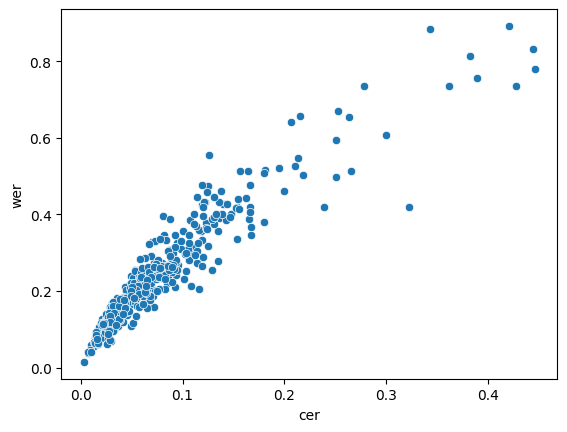

In [12]:
sns.scatterplot(data = gold_bln_df, y = 'wer', x = 'cer')

## CLOCR-C dataset

# Create single dataset



In [26]:
gold_1000_df = pd.concat([gold_smh_df, gold_ca_df, gold_bln_df])


gold_1000_df= evaluate_model(df = gold_1000_df, metric_obj = cer, gt_text = 'content', post_lm_text = 'raw_text_space', metric_name= 'cer')
gold_1000_df= evaluate_model(df = gold_1000_df, metric_obj = wer, gt_text = 'content', post_lm_text = 'raw_text_space', metric_name= 'wer')

print(gold_1000_df[['tokens_short', 'tokens_raw_short']].sum())

gold_1000_df.shape

tokens_short        390667
tokens_raw_short    438800
dtype: int64


(719, 12)

<Axes: xlabel='cer', ylabel='wer'>

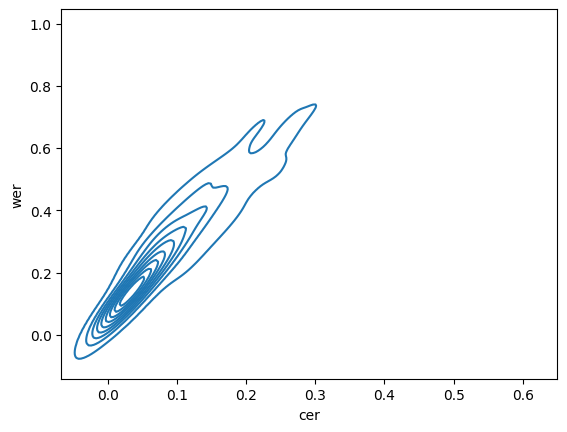

In [29]:
sns.kdeplot(data = gold_1000_df, y = 'wer', x = 'cer')

<Axes: xlabel='cer', ylabel='Density'>

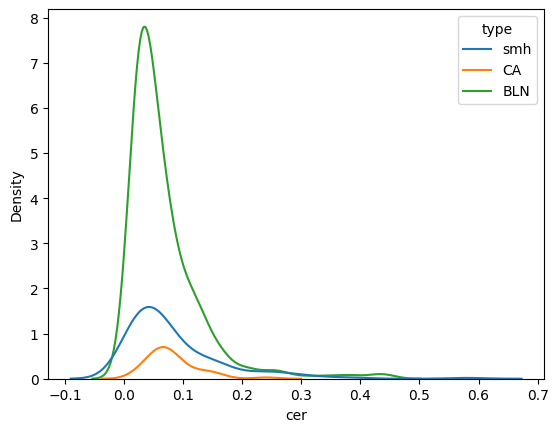

In [34]:
sns.kdeplot(data = gold_1000_df, x = 'cer', hue='type')

# Create line level dataset

This approach splits the line level datasets into smaller chunks to create more observations. The data is split into non-overlapping groups of at least 5

In [12]:

def replace_single_newline(text):
    return re.sub(r'(?<!\n)\n(?!\n)', ' ', text)

def split_rows(df, num_rows = 5, text_var = 'article_text'):
    new_rows = []
    
    for _, row in df.iterrows():
        content_lines = row[text_var].split('\n')
        num_groups = len(content_lines) // num_rows
        
        for i in range(num_groups):
            start_row = i * num_rows
            end_row = (i + 1) * num_rows
            group_lines = content_lines[start_row:end_row]
            
            new_row = {
                'file_name': row['file_name'],
                text_var: '\n'.join(group_lines),
                'start_row': start_row,
                'end_row': end_row
            }
            new_rows.append(new_row)
    
    new_df = pd.DataFrame(new_rows)
    new_df[text_var] = new_df[text_var].str.replace(r"-\n", "", regex=True)\
                                    .str.replace(r"(?<!\n)\n(?!\n)", " ", regex=True)\
                                    .str.replace(r"\n{2,}", "\n", regex=True)
    new_df['id2'] = new_df['file_name'].str.replace(".txt", "")
    new_df['id'] = new_df['id2'] + "_lines_" + new_df['start_row'].astype(str) + "_" + new_df['end_row'].astype(str) 
    new_df['file_name'] = new_df['id'] + ".txt" 
    return new_df

def create_split_row_dataset(gt_path, raw_path, num_rows, tokenizer):

    df = load_gt_and_raw_text(gt_path , raw_path )

    df_split = split_rows(df, num_rows=num_rows, text_var = 'article_text')

    df_split['tokens'] = df_split['article_text'].apply(lambda x:len(tokenizer.encode(x)))

    df_split_raw = split_rows(df, num_rows=num_rows, text_var = 'raw_text')

    df_split_raw['tokens_raw'] = df_split_raw['raw_text'].apply(lambda x:len(tokenizer.encode(x)))

    df_split = df_split.merge(df_split_raw.set_index(['start_row', 'end_row', 'id2']).drop(columns = ['id', 'file_name']), 
                                                left_on = ['start_row', 'end_row', 'id2'], right_index=True)
    
    return df_split

In [15]:
num_rows = 5
#smh silver

silver_smh_df_split = create_split_row_dataset('data/overproof/SMH/dataset1_article_level/corrected', 'data/overproof/SMH/dataset1_article_level/raw', num_rows, tokenizer)

#smh gold
gold_smh_df_split = create_split_row_dataset('data/overproof/SMH/article_level/corrected', 'data/overproof/SMH/article_level/raw', num_rows, tokenizer)

#ca gold

gold_ca_df_split =  create_split_row_dataset('data/overproof/CA/article_level/corrected','data/overproof/CA/article_level/raw', num_rows, tokenizer)

#BLN600
bln600_seq = pd.read_csv('./data/BLN600/ocr_paper_data/train.csv')

bln600_seq['tokens'] = bln600_seq['Ground Truth'].apply(lambda x: len(tokenizer.encode(x)))
bln600_seq = bln600_seq.rename(columns={'Ground Truth':"article_text", "OCR Text":"raw_text", "Sample ID":"file_name"})
bln600_seq = bln600_seq[['article_text', 'file_name', 'raw_text']]

bln600_seq_test  = pd.read_csv('./data/BLN600/ocr_paper_data/test.csv')

bln600_seq_test ['tokens'] = bln600_seq_test ['Ground Truth'].apply(lambda x: len(tokenizer.encode(x)))
bln600_seq_test  = bln600_seq_test .rename(columns={'Ground Truth':"article_text", "OCR Text":"raw_text", "Sample ID":"file_name"})
bln600_seq_test  = bln600_seq_test [['article_text', 'file_name', 'raw_text']]
bln600_seq_test  = bln600_seq_test.astype(str)

split_line_data = pd.concat([gold_ca_df_split, gold_smh_df_split, ])[['id', 'article_text', 'raw_text']].rename(columns = {'id':'file_name'})

# with bln data
large_gold_data = pd.concat([bln600_seq,split_line_data])
large_gold_data['article_text'] = large_gold_data['article_text'].apply(replace_single_newline)
large_gold_data['raw_text'] = large_gold_data['raw_text'].apply(replace_single_newline)
large_gold_data = large_gold_data.astype(str)


In [31]:
large_gold_data = DatasetDict(
    {
        'train':Dataset.from_pandas(large_gold_data),
        'test':Dataset.from_pandas(bln600_seq_test)
        }
    )



## Create NCSE test set

In [51]:

ncse_df = load_txt_files_to_df("./data/transcripts/transcription_files")

raw_ocr_df = load_txt_files_to_df("./data/transcripts/transcription_raw_ocr")
raw_ocr_df = raw_ocr_df.rename(columns={'article_text':'raw_text'})
ncse_df = ncse_df.merge(raw_ocr_df, on = 'file_name')
ncse_df['article_text']= ncse_df['article_text'].str.replace(r"\n", " ", regex=True)

Dataset.from_pandas(ncse_df).save_to_disk("./data/ncse_hf_dataset")


Saving the dataset (0/1 shards):   0%|          | 0/91 [00:00<?, ? examples/s]

Dataset({
    features: ['article_text', 'file_name', 'raw_text'],
    num_rows: 91
})

In [44]:


def gen_batches_train(ds):



    for sample in iter(ds):


        # Extract instruction and input from the sample
        instruction = "You are an expert in post-OCR correction of historical newspapers. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. Do not write anything else than the corrected text."
        input_text = str(sample['article_text'])
        out_text = str(sample['raw_text'])
        formatted_prompt = None 
            
        formatted_prompt = (
            f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n"
            f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{input_text}\n\n### Response:\n"
            f"<|eot_id|><|start_header_id|>asssitant<|end_header_id|>\n\n"
            f"{str(out_text)}"
            f"<|eot_id|><|end_of_text|>"
        )
        
        formatted_prompt = "".join(formatted_prompt)
        return {'text': formatted_prompt}


def promp_formatter(sample):

        instruction = "You are an expert in post-OCR correction of historical newspapers. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. Do not write anything else than the corrected text."
        input_text = str(sample['article_text'])
        out_text = str(sample['raw_text'])
        formatted_prompt = None 
            
        formatted_prompt = (
            f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n"
            f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{input_text}\n\n### Response:\n"
            f"<|eot_id|><|start_header_id|>asssitant<|end_header_id|>\n\n"
            f"{str(out_text)}"
            f"<|eot_id|><|end_of_text|>"
        )
        
        formatted_prompt = "".join(formatted_prompt)
        return {'text': formatted_prompt}



In [46]:
test = large_gold_data.map(promp_formatter)

Map:   0%|          | 0/12492 [00:00<?, ? examples/s]

Map:   0%|          | 0/2792 [00:00<?, ? examples/s]

In [48]:
test['train'][0]['text']

"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nBelow is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nYou are an expert in post-OCR correction of historical newspapers. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. Do not write anything else than the corrected text.\n\n### Input:\nROBBERY AT A BARONETS.\n\n### Response:\n<|eot_id|><|start_header_id|>asssitant<|end_header_id|>\n\n__RO BBERY AT A BARONET'S.<|eot_id|><|end_of_text|>"

In [20]:

large_gold_data.to_parquet('./data/large_gold_data.parquet')

In [34]:
large_gold_data.save_to_disk("./data/large_gold_data")#.to_csv('./data/large_gold_data.csv')

Saving the dataset (0/1 shards):   0%|          | 0/12492 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2792 [00:00<?, ? examples/s]

In [85]:
gold_ca_df_split.loc[5,'raw_text']

'day people had to Wait for over an hour for their mail while the gentle man would talk with any person of influence that would happen along and would not allow tho clerks to'

In [115]:



print(split_line_data.shape)
split_line_data.filter(regex = 'tokens').sum()

(2092, 3)


Series([], dtype: float64)

# Fine Tune GPT4o-mini

GPT40-mini is free to fine tune for the next couple of months, it is worth testing it out as if it gets good results using it on batch is so cheap that recovering the dataset using it would be worth it.

In [61]:
base_gold_data

,article_text,file_name,raw_text
0,THE ALLEGED CHARITY FRAUDS.\n\nAt Bow-street p...,3206244076.txt,THE ALLEGED CHARITY FRPAUDS. At ]3ow-strecb ro...
1,RELIGION NOT THE FOF OF ENJOYMENT.\n\nEven Jes...,3206320475.txt,It.RFL[GION KOT THE Fon o~ N3TO!IENT: Even Jee...
2,EXPLOSION ON THE THAMES.\n\nAbout nine o'clock...,3206232857.txt,- EkPLOMON ON THE THAMES-. 3 About nine o'cloc...
3,APPREHENDED ON THE HONEYMOON.\n\nAT the Kingst...,3200810285.txt,APP=B2NDED ON TEH&: HONZI0N- AT the lRi:gston-...
4,LATEST FOREIGN NEWS.\n\nLLOYD'S WEEKLY NEWSPAP...,3206200618.txt,LATEST FOREIGN NEWS. LLOYD'S WEEKLY NEWSPAPER ...
...,...,...,...
154,EARTHQUAKE NEAR ALICE SPRINGS. RECORDED IN SYD...,27945000_year_1941_type_Article_title_The_Sydn...,EARTHQUAKE NEAR ALICE SPRINGS. RECORDED IN SYD...
155,MR. ALEXANDER VEITCH. Many of the bowlers and ...,16443000_year_1928_type_Article_title_The_Sydn...,MR. ALEXANDER VEITCH. Many of the hotvlors nnd...
156,"Magistrate Bars Mr. Evatt -- Mr Beavers, S.M.,...",18235000_year_1951_type_Article_title_The_Sydn...,"Magistrate Bars Mr. Evatt -1 Mr Beavers, S.M.,..."
157,SHIPPING INTELLIGENCE. ARRIVALS. OCTOBER 4.- M...,12931000_year_1851_type_Article_title_The_Sydn...,SHIPPING INTELLIGENCE. ARRIVALS. OCTOBER 4.-Ma...


In [74]:
BLN_df = load_txt_files_to_df('data/BLN600/Ground Truth').merge(
    load_txt_files_to_df('data/BLN600/OCR Text').set_index('file_name').rename(columns = {'article_text':'raw_text'}), left_on = 'file_name', right_index=True
)


CA_df = load_txt_files_to_df('data/overproof/CA/article_level/corrected').merge(
    load_txt_files_to_df('data/overproof/CA/article_level/raw').set_index('file_name').rename(columns = {'article_text':'raw_text'}), left_on = 'file_name', right_index=True
)

silver_SMH_df = load_txt_files_to_df('data/overproof/SMH/dataset1_article_level/corrected').merge(
    load_txt_files_to_df('data/overproof/SMH/dataset1_article_level/raw').set_index('file_name').rename(columns = {'article_text':'raw_text'}), left_on = 'file_name', right_index=True
)

gold_SMH_df = load_txt_files_to_df('data/overproof/SMH/article_level/corrected').merge(
    load_txt_files_to_df('data/overproof/SMH/article_level/raw').set_index('file_name').rename(columns = {'article_text':'raw_text'}), left_on = 'file_name', right_index=True
)


#used for validation/test
ncse_df = load_txt_files_to_df('data/transcripts/transcription_files').merge(
    load_txt_files_to_df('data/transcripts/transcription_raw_ocr').set_index('file_name').rename(columns = {'article_text':'raw_text'}), left_on = 'file_name', right_index=True
)


base_silver_data = pd.concat([BLN_df, CA_df, silver_SMH_df])
base_silver_data['article_text'] = base_silver_data['article_text'].apply(replace_single_newline)
base_silver_data['raw_text'] = base_silver_data['raw_text'].apply(replace_single_newline)


#smaller but higher quality
base_gold_data = pd.concat([BLN_df, CA_df, gold_SMH_df])
base_gold_data['article_text'] = base_gold_data['article_text'].apply(replace_single_newline)
base_gold_data['raw_text'] = base_gold_data['raw_text'].apply(replace_single_newline)


#Create the NCSE set as test
ncse_df['article_text'] = ncse_df['article_text'].apply(replace_single_newline)
ncse_df['raw_text'] = ncse_df['raw_text'].apply(replace_single_newline)

In [77]:
large_gold_data['article_text'].apply(lambda x:len(tokenizer.encode(x))).sum()

np.int64(260138)

In [79]:
def create_training_jsonl(df, system_content, output_file):
    """
    Create a JSONL file for fine tuning a gpt model.

    Parameters:
    df (pd.DataFrame): DataFrame containing the input and output text.
    system_content (str): The content for the system message.
    output_file (str): The path to the output JSONL file.
    """
    with open(output_file, 'w') as file:
        for _, row in df.iterrows():
            messages = [
                {"role": "system", "content": system_content},
                {"role": "user", "content": row['raw_text']},
                {"role": "assistant", "content": row["article_text"]}
            ]
            # Write each JSON object as a separate line in the JSONL file
            file.write(json.dumps({'messages':messages}) + '\n')

In [80]:
create_training_jsonl(base_silver_data, silver_instructions_historical,  './data/gpt_mini_training/silver_instructions_historical_training.jsonl')

create_training_jsonl(base_gold_data, silver_instructions_historical,  './data/gpt_mini_training/gold_instructions_historical_training.jsonl')

create_training_jsonl(large_gold_data, silver_instructions_historical,  './data/gpt_mini_training/large_gold_instructions_historical_training.jsonl')

create_training_jsonl(ncse_df,silver_instructions_historical,  './data/gpt_mini_training/ncse_instructions_historical_validation.jsonl')

In [103]:
#testing the split data approach as it produces many more observations that are individually easier to to solve
create_training_jsonl(split_line_data, silver_instructions_historical,  './data/gpt_mini_training/gold_split_historical_training.jsonl')



create_training_jsonl(large_gold_data, silver_instructions_historical,  './data/gpt_mini_training/large_gold_split_historical_training.jsonl')

In [105]:
data_path =  './data/gpt_mini_training/large_gold_split_historical_training.jsonl'#'./data/gpt_mini_training/gold_instructions_historical_training.jsonl'# './data/gpt_mini_training/silver_instructions_historical_training.jsonl'

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 12492
First example:
{'role': 'system', 'content': 'You are an expert in post-OCR correction of historical newspapers. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. Do not write anything else than the corrected text.'}
{'role': 'user', 'content': "__RO BBERY AT A BARONET'S."}
{'role': 'assistant', 'content': 'ROBBERY AT A BARONETS.'}


In [118]:
from collections import defaultdict

#dataset = ncse_df

# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [106]:
client.files.create(
  file=open('./data/gpt_mini_training/large_gold_split_historical_training.jsonl', "rb"),
  purpose="fine-tune"
)



FileObject(id='file-uQyAJuJ5IzdGZvuxgayDmLiL', bytes=7863570, created_at=1722248650, filename='large_gold_split_historical_training.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
client.files.create(
  file=open( './data/gpt_mini_training/ncse_instructions_historical_validation.jsonl', "rb"),
  purpose="fine-tune"
)

# Use fine tuned model

In [147]:

raw_gold_ocr_df 


,article_text,file_name
0,"MONOMANIA . 5 ISCB Ox ? 0 BD "" popped"" at the ...",artid_841530_periodical_ns_issue_vm2-ncseprodu...
1,* The Plague and the Printing Press : being a ...,artid_751411_periodical_pc_issue_tec_01051889_...
2,"he performed upon diverse of the foremost , wh...",artid_871466_periodical_ns_issue_ns2_02101852_...
3,be having necessary to tramp for the into hous...,artid_494321_periodical_ewj_issue_ewj_01051860...
4,tomorrow we are going * to pillage the archbis...,artid_495935_periodical_ewj_issue_ewj_01011860...
...,...,...
86,because too much power was placed in the hands...,artid_841528_periodical_ns_issue_vm2-ncseprodu...
87,^ ^ ^ ^ ^^ ¦ ¦ ¦¦ ¦¦¦¦¦¦¦ ^ ¦¦ ¦ ¦ ^ ^ ¦ ^ ^ ¦...,artid_766218_periodical_pc_issue_tec_01031886_...
88,Boo &§; and ^ mou ^ ofBoo & £ Miss Braddon avv...,artid_771187_periodical_pc_issue_tec_15091890_...
89,have been-designed : ihere may therefore be th...,artid_653700_periodical_mruc_issue_vm2-ncsepro...


In [107]:
raw_transcript_oct_folder = './data/transcripts/transcription_raw_ocr'

#These are referred to as "gold" as this clearly distinguishes the dataset from any dataframes called test or for testing things in general
raw_gold_ocr_df = load_txt_files_to_df(raw_transcript_oct_folder)

fine_tune_model = 'ft:gpt-4o-mini-2024-07-18:personal:large-gold-v1:9qIvPFOF'

create_jsonl_file(raw_gold_ocr_df, fine_tune_model, silver_instructions_historical, 8000, './data/gpt_mini_training/ncse_test_instructions_historical_large_gold_split.jsonl')

In [108]:
batch_input_file = client.files.create(
  file=open( './data/gpt_mini_training/ncse_test_instructions_historical_large_gold_split.jsonl', "rb"),
  purpose="batch"
)

batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "ft_ncse_test_instructions_historical_large_gold_split"
    }
)

Batch(id='batch_9jdFMN3MvvucPKSxg0jGPD3T', completion_window='24h', created_at=1722253897, endpoint='/v1/chat/completions', input_file_id='file-TmyhsUqpjNgFu01RDrYzwLbO', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1722340297, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'ft_ncse_test_instructions_historical_large_gold_split'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

# Load the fine tuned results

In [ ]:
def pre_evaluation_processing(df, ground_truth_df, post_lm_text, gt_text ):
    df['id'] = df['id'].str.replace('filename_', '')

    df = df.merge(ground_truth_df.set_index('file_name'), left_on = 'id', right_index = True)
    #df['post_lm_text2'] = df['post_lm_text'].apply(extract_first_match)
    df[post_lm_text] = df[post_lm_text].str.replace("\n*", " ").str.lower()
    df[gt_text] = df[gt_text].str.replace("\n*", " ").str.lower()
    df.reset_index(inplace=True)

    return df

In [11]:
silver_instructions_between = convert_opanai_jsonl_to_df('data/gpt_mini_training/results_ft_v1_ncse_test_instructions_historical.jsonl')
silver_instructions_between = pre_evaluation_processing(silver_instructions_between, corrected_gold_ocr_df, post_lm_text= 'post_lm_text', gt_text = 'article_text' )

silver_instructions_between = evaluate_model(df = silver_instructions_between, metric_obj = cer, gt_text = 'article_text', post_lm_text = 'post_lm_text')
silver_instructions_between['ERP'] = (silver_instructions_between['cer_orig'] - silver_instructions_between['cer'])/silver_instructions_between['cer_orig'] 


,cer,ERP
count,91.000000,91.000000
mean,1.334742,-1.230697
std,5.891574,8.317382
min,0.000000,-74.935294
25%,0.017292,-0.045655
50%,0.135751,0.298439
75%,0.579506,0.720940
max,53.123457,1.000000


In [26]:
silver_instructions_between.sort_values('ERP')

,index,id,post_lm_text,prompt_tokens,completion_tokens,total_tokens,article_text,cer_orig,cer,ERP
71,71,artid_730702_periodical_pc_issue_tec_15031884_...,[ 14 items by j -r. 3nw pocket part of 5standa...,3689,1259,4948,melun – sister rosalie of the order of charity...,0.722671,0.745128,-0.031075
54,54,artid_800002_periodical_t_issue_ttw_14091867_p...,( d ' apres malherbe . ) donc un nouveau labou...,336,267,603,les maires d'arras de lille et d'amiens a l'e...,0.112309,0.107817,0.040000
90,90,artid_802845_periodical_t_issue_ttw_16051868_p...,for the use of our young friends. ( continued ...,409,330,739,woman's word-book.for the use of our young fri...,0.547142,0.517446,0.054274
28,28,artid_491860_periodical_ewj_issue_ewj_01081858...,"of agencies this world has to survive, alignin...",759,417,1176,gences; this only is the result which shall su...,0.497685,0.467923,0.059801
55,55,artid_799563_periodical_t_issue_ttw_21121867_p...,dr. culverwell's 19 st martin'sle turkish - gr...,161,90,251,"dr. culverwell's turkish baths, removed from 1...",0.738462,0.692308,0.062500
...,...,...,...,...,...,...,...,...,...,...
51,51,artid_666934_periodical_mruc_issue_vm2-ncsepro...,"become one, or a unity, in the thinking subjec...",889,813,1702,"become one, or a unity, in the thinking subjec...",0.035079,0.003869,0.889706
67,67,artid_409455_periodical_l_issue_cld_30071853_p...,"affirming mr. gladstone's resolution, by 117 t...",1417,1225,2642,"affirming mr. gladstone's resolution, by 117 t...",0.072973,0.007601,0.895833
38,38,artid_871467_periodical_ns_issue_ns2_02101852_...,terrible as was never seen or heard of in the ...,189,131,320,terrible as was never seen or heard of in the ...,0.045045,0.003604,0.920000
15,15,artid_649792_periodical_mruc_issue_vm2-ncsepro...,ingenious and smart but appears to us not to c...,192,123,315,"ingenious and smart, but appears to us not to ...",0.064736,0.003407,0.947368


In [17]:
silver_instructions_between.loc[41, 'post_lm_text']

'foreign books and periodicals messrs sedgwick foreign works and periodicals to the trade 3 westbourne grove mabsto of per , & co the . most liberal supply terms 3a large stock of popular foreign educational , historical , literary , and scientific works always on hand . n . b .-catalogues gratis on application . fast teaii parcels from the continent twice a week , crown buildings , 188 fleet street , e . c . london . for governments, teachers, and brickmakers. the artificial manufacture of brick, by h. m. sptzek. price three pounds.\n\nbricks upon the cotton system in frick code. st. louis, dec. 9. - the st. louis brick and glass manufacturing company are working ten kilns on the cotton system. the first was finished two months ago, and the bricks are pronounced a no. 1. it has only been in operating two months, and in that time 500,000 bricks have been made.\n\nthe influence of the brick trade. - the annual value of the trade in bricks in the united kingdom is over 7,000,000l., while

In [ ]:
silver_instructions_between[['cer', 'ERP']].describe()

In [34]:
silver_instructions_between = convert_opanai_jsonl_to_df('data/gpt_mini_training/result_gold_split.jsonl')
silver_instructions_between = pre_evaluation_processing(silver_instructions_between, corrected_gold_ocr_df, post_lm_text= 'post_lm_text', gt_text = 'article_text' )

silver_instructions_between = evaluate_model(df = silver_instructions_between, metric_obj = cer, gt_text = 'article_text', post_lm_text = 'post_lm_text')
silver_instructions_between['ERP'] = (silver_instructions_between['cer_orig'] - silver_instructions_between['cer'])/silver_instructions_between['cer_orig'] 
silver_instructions_between[['cer', 'ERP']].describe()

,cer,ERP
count,91.000000,91.000000
mean,0.235390,0.446764
std,0.248386,0.280869
min,0.000000,-0.031075
25%,0.016640,0.192822
50%,0.107817,0.454183
75%,0.453857,0.694260
max,1.161290,1.000000


In [109]:

silver_instructions_between = convert_opanai_jsonl_to_df('data/gpt_mini_training/result_gold_large_split.jsonl')
silver_instructions_between = pre_evaluation_processing(silver_instructions_between, corrected_gold_ocr_df, post_lm_text= 'post_lm_text', gt_text = 'article_text' )

silver_instructions_between = evaluate_model(df = silver_instructions_between, metric_obj = cer, gt_text = 'article_text', post_lm_text = 'post_lm_text')
silver_instructions_between['ERP'] = (silver_instructions_between['cer_orig'] - silver_instructions_between['cer'])/silver_instructions_between['cer_orig'] 
silver_instructions_between[['cer', 'ERP']].describe()

,cer,ERP
count,91.000000,91.000000
mean,0.273238,0.279623
std,0.302247,1.260291
min,0.000000,-10.545322
25%,0.012378,0.164798
50%,0.096626,0.438416
75%,0.501473,0.782271
max,1.639785,1.000000


In [31]:
silver_instructions_between.loc[55, 'post_lm_text']

'dr. culverwell\'s 19 st martin\'sle turkish - grand baths , city rd , 3 r removed great marl from the borough tickets , is . 6 d . street twenty , 21 r.s. , saturdays at exeter street , 28 w. —advice single is on ., bath menu gratis , cornhill. dr. c\'s : medical work , "ourselves,"'

In [30]:
silver_instructions_between.loc[55, 'article_text']

'dr. culverwell\'s turkish baths, removed from 19 st. martin\'s-le-grand, city, to 3 great marlborough street. regent street, w. – single tickets, 1s. 6d.; twenty, 21s. saturdays, 1s. advice on bath gratis. dr. c\'s. medical work, "ourselves," is., mann, cornhill.'

In [33]:
silver_instructions_between.sort_values('ERP')

,index,id,post_lm_text,prompt_tokens,completion_tokens,total_tokens,article_text,cer_orig,cer,ERP
18,18,artid_493911_periodical_ewj_issue_ewj_01031859...,to appoint a successor and associate him with ...,790,822,1612,to appoint a successor and associate him with ...,0.129397,0.852210,-5.586035
65,65,artid_493205_periodical_ewj_issue_ewj_01051859...,would also sadly not have deficient presented ...,362,549,911,"also sadly deficient in visitors, or the neces...",0.553557,1.519215,-1.744461
88,88,artid_771187_periodical_pc_issue_tec_15091890_...,a esq. and 5 months of mr. and mrs. braddon...,1303,1625,2928,books and rumours of booksmiss braddon's new n...,0.705517,1.695172,-1.402737
79,79,artid_802535_periodical_t_issue_ttw_25011868_p...,ral honest irish manner . we are a-going to ha...,1297,1274,2571,rale honest irish manner. we are a-going to ha...,0.845665,1.665546,-0.969510
43,43,artid_490621_periodical_ewj_issue_ewj_01091858...,ject before their professional critics. the su...,884,1022,1906,before it: the difficulty seems to be in the w...,0.591636,1.091636,-0.845114
...,...,...,...,...,...,...,...,...,...,...
64,64,artid_586631_periodical_l_issue_vm2-ncseproduc...,"obituary general sir richard bourke, k.c.b., h...",396,334,730,"obituary. general sir richard boirke, k.c.b., ...",0.040055,0.007597,0.810345
81,81,artid_604837_periodical_mruc_issue_vm2-ncsepro...,"portant tenets, and to which therefore they we...",396,309,705,"portant light, and to which therefore they wer...",0.056818,0.010732,0.811111
29,29,artid_604838_periodical_mruc_issue_vm2-ncsepro...,"the most part the first converts learned ""the ...",396,309,705,the most part the first “who learned the way o...,0.060013,0.010107,0.831579
52,52,artid_800000_periodical_t_issue_ttw_14091867_p...,we are truly sorry to have been the innocent v...,230,176,406,we are truly sorry to have been the innocent v...,0.021327,0.003555,0.833333
